In [1]:
# Manually upload zipped folder and unzip (also renamed it to image-datasets)
!unzip /content/image-datasets.zip

Archive:  /content/image-datasets.zip
replace __MACOSX/._image-datasets? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [2]:
import requests, re, time
import torch, torchvision

from torch import nn, optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

from torch.utils.mobile_optimizer import optimize_for_mobile

In [3]:
xform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
dataset_full = datasets.ImageFolder('/content/image-datasets', transform=xform)

In [4]:
# Sanity check:
dataset_full[0][0].shape

torch.Size([3, 224, 224])

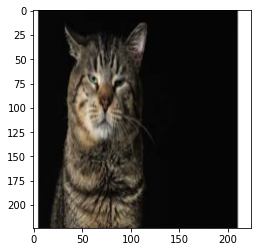

In [5]:
# Checking contents:
plt.imshow(dataset_full[5][0].permute(1,2,0))

Labels for angry=0;
happy=1;
sad=2;
sleepy=3


In [6]:
n_all = len(dataset_full)
n_train = int(0.8 * n_all)
n_test = n_all - n_train
rng = torch.Generator().manual_seed(906)
dataset_train, dataset_test = torch.utils.data.random_split(dataset_full, [n_train, n_test], rng)

In [7]:
#dataset_test_correctlabel=[(sample,label-1) for sample,label in dataset_test]
#dataset_train_correctlabel=[(sample,label-1) for sample,label in dataset_train]

In [8]:
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size = 4, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size = 4, shuffle=True)

In [9]:
model = models.resnet18(pretrained=True)

In [10]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [11]:
model.fc = nn.Linear(model.fc.in_features, 4)
torch.nn.init.xavier_uniform_(model.fc.weight)

Parameter containing:
tensor([[-0.0490, -0.0361, -0.0911,  ..., -0.0939,  0.0271, -0.0348],
        [ 0.0085, -0.0492,  0.0599,  ..., -0.0272,  0.0038,  0.0943],
        [-0.1026, -0.0550,  0.0287,  ...,  0.0062,  0.0923, -0.0880],
        [ 0.0662,  0.0949,  0.0887,  ...,  0.0291, -0.0817,  0.0620]],
       requires_grad=True)

In [12]:
torch.cuda.device_count()

1

In [13]:
device = torch.device('cuda:0')
model = model.to(device)

In [14]:
# Created class that takes learning rate, momentum factor, learning rate scheduler, and minibatch size to easily change variables and experiment for Task 5
class TransferLearning:


   def __init__(self, learning_rate, momentum_factor, learning_rate_scheduler, minibatch_size, stepSize):
     self.criterion = nn.CrossEntropyLoss()
     self.optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum_factor)
     self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=stepSize, gamma=learning_rate_scheduler)
     self.loss_test = 0;
     self.epoch_num = 0;
  
   def run_test(self, model):
     nsamples_test = len(dataset_test)
     loss, correct = 0, 0
     model.eval()
     with torch.no_grad():
         for samples, labels in loader_test:
             samples = samples.to(device)
             labels = labels.to(device)
             outs = model(samples)
             loss += self.criterion(outs, labels)
             _, preds = torch.max(outs.detach(), 1)
             correct_mask = preds == labels
             correct += correct_mask.sum(0).item()
     return loss / nsamples_test, correct / nsamples_test

   def run_train(self, model):
     nsamples_train = len(dataset_train)
     loss_sofar, correct_sofar = 0, 0
     model.train()
     with torch.enable_grad():
         for samples, labels in loader_train:
             samples = samples.to(device)
             labels = labels.to(device)
             self.optimizer.zero_grad()
             outs = model(samples)
             _, preds = torch.max(outs.detach(), 1)
             loss = self.criterion(outs, labels)
             loss.backward()
             self.optimizer.step()
             loss_sofar += loss.item() * samples.size(0)
             correct_sofar += torch.sum(preds == labels.detach())
     self.scheduler.step()
     return loss_sofar / nsamples_train, correct_sofar / nsamples_train

   def run_all(self, model, n_epochs):
     for epoch in range(n_epochs):
         loss_train, acc_train = self.run_train(model)
         self.loss_test, acc_test = self.run_test(model)
         print(f"epoch {self.epoch_num + epoch}: train loss {loss_train:.4f} acc {acc_train:.4f}, test loss {self.loss_test:.4f} acc {acc_test:.4f}")
     self.epoch_num = self.epoch_num + n_epochs

In [15]:
# accuracy without training
learn = TransferLearning(0.0005, 0.9, 0.1, 1, 8)
learn.run_test(model)

(tensor(0.5926, device='cuda:0'), 0.252212389380531)

In [16]:
learn.run_all(model, 10)
prev_loss = learn.loss_test

while True:
  learn.run_all(model, 1)
  loss_difference = prev_loss - learn.loss_test
  if (learn.epoch_num > 20):
    break
  prev_loss = learn.loss_test

epoch 0: train loss 1.3633 acc 0.4500, test loss 0.3928 acc 0.3982
epoch 1: train loss 1.0118 acc 0.6011, test loss 0.2689 acc 0.6283
epoch 2: train loss 0.7111 acc 0.7267, test loss 0.2603 acc 0.6460
epoch 3: train loss 0.5714 acc 0.7956, test loss 0.2813 acc 0.6372
epoch 4: train loss 0.4626 acc 0.8322, test loss 0.2903 acc 0.6327
epoch 5: train loss 0.3295 acc 0.8789, test loss 0.2792 acc 0.6460
epoch 6: train loss 0.2683 acc 0.9056, test loss 0.3302 acc 0.6150
epoch 7: train loss 0.2596 acc 0.9067, test loss 0.3358 acc 0.6416
epoch 8: train loss 0.2151 acc 0.9211, test loss 0.3099 acc 0.6637
epoch 9: train loss 0.1810 acc 0.9422, test loss 0.3060 acc 0.6593
epoch 10: train loss 0.1520 acc 0.9511, test loss 0.2970 acc 0.6637
epoch 11: train loss 0.1649 acc 0.9467, test loss 0.2965 acc 0.6726
epoch 12: train loss 0.1324 acc 0.9533, test loss 0.3029 acc 0.6549
epoch 13: train loss 0.1096 acc 0.9633, test loss 0.3036 acc 0.6681
epoch 14: train loss 0.1220 acc 0.9567, test loss 0.3001 a

Optimizing Parameters:

* Top section of the table contains optimized parameters that are compatible with our app integration model

* Bottom section of the table contains overall optimized parameters (not necessarily compatible with app)

| learning rate | momentum | step size | gamma | minibatch | test loss | test acc | best epoch |
|---------------|----------|-----------|-------|-----------|-----------|----------|------------|
| ...           | ...      | ...       | ...   | ...       | ...       | ...      | ...        |
| **0.0005** | **0.9** | **8** | **0.1** | 1 | 0.2718  | 0.7035| 14
| **0.0005** | **0.9** | **8** | 0.9 | 1 | 0.3730  | 0.6504| 10
| **0.0005** | **0.9** | **8** | 0.5 | 1 | 0.3148  | 0.6770| 9
| **0.0005** | **0.9** | 4 | 0.1 | 1 | 0.2684  | 0.6504| 10
| **0.0005** | **0.9** | 12 | 0.1 | 1 | 0.3088  | 0.6726| 17
| **0.0005** | **0.9** | 10 | 0.1 | 1 | 0.3179  | 0.6681| 19
| **0.0005** | **0.9** | 5 | 0.1 | 1 | 0.2794  | 0.6637| 16
| **0.0005** | 0.5 | **8** | 0.1 | 1 | 0.2414  | 0.6593 | 6
| **0.0005** | 0.2 | **8** | 0.1 | 1 | 0.2622  | 0.6239 | 13
| 0.005 | **0.9** | **8** | 0.1 | 1 | 0.4175  | 0.4248 | 10
| 0.01 | **0.9** | **8** | 0.1 | 1 | 0.3620  | 0.3850 | 12
| 0.000001 | **0.9** | **8** | 0.1 | 1 | 0.3788 | 0.3496 | 12
| 0.1 | **0.9** | **8** | 0.1 | 1 | 0.3922 | 0.3142 | 19
| 0.001 | **0.9** | **8** | 0.1 | 1 | 0.3316 | 0.6549 | 11
| ... | ... | ... | ... | ... | ... | ... | ... |
| 0.001 | 0.9 | 8 | 0.1 | 5 | 0.3408 | 0.6637 | 20
| 0.1 | 0.9 | 8 | 0.1 | 5 | 0.3492 | 0.4027 | 12
| 0.000001 | 0.9 | 8 | 0.1 | 5 | 0.4359 | 0.3363 | 20
| 0.01 | 0.9 | 8 | 0.1 | 5 | 0.3217 | 0.4292 | 20
| 0.005 | 0.9 | 8 | 0.1 | 5 | 0.3417 | 0.4381 | 8
| **0.0005** | 0.5 | 8 | 0.1 | 5 | 0.2521 | 0.6062 | 11
| **0.0005** | 0.2| 8 | 0.1 | 5 | 0.2577 | 0.6239 | 14
| **0.0005** | 0.8| 8 | 0.1 | 5 | 0.2682 | 0.6681 | 11
| **0.0005** | **0.9** | 5 | 0.1 | 5 | 0.3160 | 0.6549 | 19
| **0.0005** | **0.9** | 10 | 0.1 | 5 | 0.2862 | 0.6858 | 14
| **0.0005** | **0.9** | 12 | 0.1 | 5 | 0.3171 | 0.6637 | 16
| **0.0005** | **0.9** | **8** | 0.5 | 5 | 0.3367 | 0.6726 | 17
| **0.0005** | **0.9** | **8** | 0.9 | 5 | 0.3137 | 0.6504 | 11
| **0.0005** | **0.9** | **8** | **0.1** | 5 | 0.2966 | 0.6903 | 20
| **0.0005** | **0.9** | **8** | **0.1** | 8 | 0.3185 | 0.6549 | 14
| **0.0005** | **0.9** | **8** | **0.1** | 3 | 0.2908 | 0.6814 | 11
| **0.0005** | **0.9** | **8** | **0.1** | 2 | 0.2872 | 0.6504 | 10
| **0.0005** | **0.9** | **8** | **0.1** | **4** | 0.2834 | 0.7168 | 20


May use transforms.Rotation/VerticalFlip/... 

In [17]:
# In case we need more data:

# RandomGrayscale and RandomHorizontalFlip used here (but final probability decided on - after testing - is 1):
#yform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.RandomGrayscale(0.5), transforms.RandomHorizontalFlip(0.5)])
#dataset_full = datasets.ImageFolder('/content//image-datasets', transform=yform)

In [18]:
# Code taken from tutorial video at https://www.youtube.com/watch?v=5Lxuu16_28o&ab_channel=PyTorch

model.qconfig = torch.quantization.get_default_qconfig('qnnpack')

In [19]:
torch.quantization.prepare(model,inplace=True)

ResNet(
  (conv1): Conv2d(
    3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
    (activation_post_process): HistogramObserver()
  )
  (bn1): BatchNorm2d(
    64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (activation_post_process): HistogramObserver()
  )
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(
        64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
        (activation_post_process): HistogramObserver()
      )
      (bn1): BatchNorm2d(
        64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (activation_post_process): HistogramObserver()
      )
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(
        64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
        (activation_post_process): HistogramObserver()
      )
      (bn2

In [20]:
# def calibrate(model,calibration_data):
#   return
# calibrate(model, [])

In [21]:
model_quant = torch.quantization.QuantStub()

In [22]:
model = torch.quantization.convert(model_quant,inplace=True)

In [23]:
torchscript_model = torch.jit.script(model)

In [24]:
torchscript_model_optimized = optimize_for_mobile(torchscript_model)

In [27]:
torch.jit.save(torchscript_model_optimized, 'image_model.pt')